In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import json
import joblib 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

plt.rcParams["figure.figsize"] = (10, 5)

BASE_DIR = Path.cwd().parents[0]
CLEAN_PATH = BASE_DIR / "data" / "cleaned" / "nyc_311_sample_cleaned.parquet"

CLEAN_PATH, CLEAN_PATH.exists()

(PosixPath('/Users/yerapark/Documents/GitHub/nyc-311-service-analysis/data/cleaned/nyc_311_sample_cleaned.parquet'),
 True)

In [24]:
df = pd.read_parquet(CLEAN_PATH)
df.head(), df.shape

(   unique_key        created_date agency                      agency_name  \
 0    67256893 2025-12-22 02:04:57   NYPD  New York City Police Department   
 1    67260939 2025-12-22 02:00:56   NYPD  New York City Police Department   
 2    67260900 2025-12-22 01:54:08   NYPD  New York City Police Department   
 3    67256319 2025-12-22 01:53:17   NYPD  New York City Police Department   
 4    67260805 2025-12-22 01:52:16   NYPD  New York City Police Department   
 
         complaint_type          descriptor descriptor_2  \
 0   Noise - Commercial    Loud Music/Party         None   
 1  Noise - Residential    Loud Music/Party         None   
 2  Noise - Residential    Banging/Pounding         None   
 3    Abandoned Vehicle  With License Plate         None   
 4     Blocked Driveway           No Access         None   
 
                 location_type  incident_zip     incident_address  ...  \
 0            Store/Commercial       10012.0     18 SPRING STREET  ...   
 1  Residential Buil

In [25]:
df.isna().mean().sort_values(ascending=False).head(15)

taxi_company_borough        1.000000
taxi_pick_up_location       1.000000
facility_type               1.000000
due_date                    1.000000
road_ramp                   0.999092
bridge_highway_direction    0.998183
bridge_highway_name         0.993641
bridge_highway_segment      0.993641
vehicle_type                0.921512
descriptor_2                0.920967
landmark                    0.128270
bbl                         0.088663
cross_street_1              0.084847
cross_street_2              0.083757
intersection_street_1       0.081395
dtype: float64

In [26]:
df["resolution_hours"].describe()

count    5504.000000
mean        2.412137
std         3.345039
min         0.000000
25%         0.509931
50%         1.169167
75%         2.717083
max        24.387778
Name: resolution_hours, dtype: float64

In [27]:
df["complaint_type"].value_counts().head(10)
df["borough"].value_counts()
df["agency"].value_counts().head(10)

agency
NYPD     4892
DOB       188
HPD       143
DEP        76
DOT        70
DSNY       67
DHS        35
DPR        17
DOHMH      16
Name: count, dtype: int64

In [28]:
target_col = "resolution_hours"

feature_cols = [
    "complaint_type",
    "borough",
    "agency",
    "month",
    "hour",
    "weekday",
    "is_weekend",
]

# Keep only rows without missing in these columns
df_model = df.dropna(subset=feature_cols + [target_col]).copy()

X_raw = df_model[feature_cols]
y = df_model[target_col]

X_raw.head()

,complaint_type,borough,agency,month,hour,weekday,is_weekend
0,Noise - Commercial,MANHATTAN,NYPD,12,2,0,0
1,Noise - Residential,MANHATTAN,NYPD,12,2,0,0
2,Noise - Residential,BROOKLYN,NYPD,12,1,0,0
3,Abandoned Vehicle,QUEENS,NYPD,12,1,0,0
4,Blocked Driveway,QUEENS,NYPD,12,1,0,0


In [29]:
categorical_cols = ["complaint_type", "borough", "agency"]
numeric_cols = ["month", "hour", "weekday", "is_weekend"]

X_categorical = pd.get_dummies(X_raw[categorical_cols], drop_first=True)
X_numeric = X_raw[numeric_cols]

X = pd.concat([X_numeric, X_categorical], axis=1)

X.shape, y.shape

((5504, 64), (5504,))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((4403, 64), (1101, 64))

In [31]:
baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)

y_pred_baseline = baseline.predict(X_test)

baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_r2 = r2_score(y_test, y_pred_baseline)

baseline_mae, baseline_r2

(2.3172203924323655, -0.00147785460336336)

In [32]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_lr = linreg.predict(X_test)

lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

lr_mae, lr_r2

(2.026560034174288, 0.2607737695601531)

In [33]:
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

rf_mae, rf_r2

(1.785377749856917, 0.35637556658190306)

In [34]:
results = pd.DataFrame({
    "model": ["Baseline (mean)", "Linear Regression", "Random Forest"],
    "MAE": [baseline_mae, lr_mae, rf_mae],
    "R2": [baseline_r2, lr_r2, rf_r2],
})

results

,model,MAE,R2
0,Baseline (mean),2.317220,-0.001478
1,Linear Regression,2.026560,0.260774
2,Random Forest,1.785378,0.356376


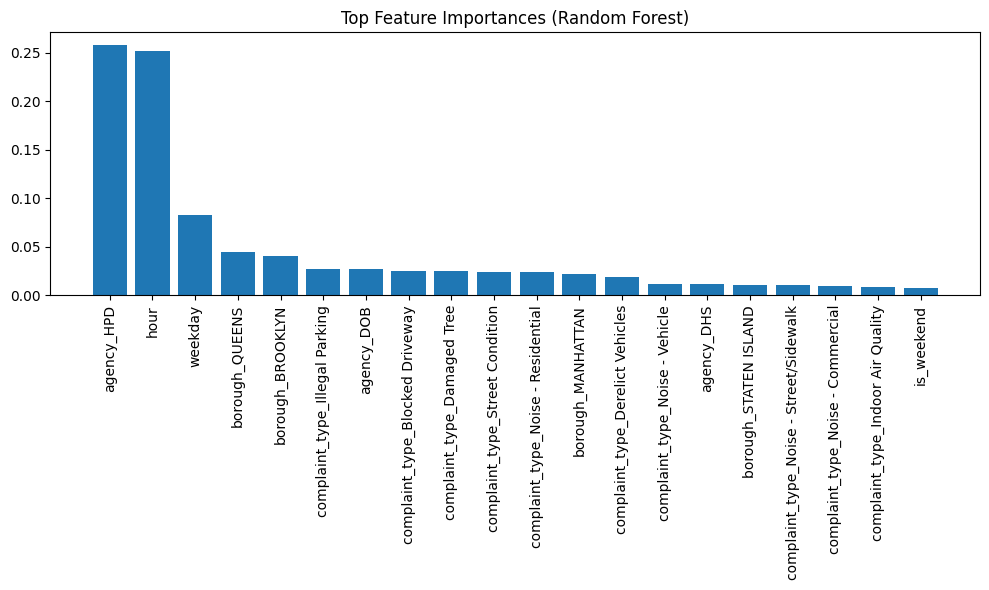

In [35]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

feature_names = X.columns

top_n = 20  # show top 20 features
top_idx = indices[:top_n]

plt.figure(figsize=(10, 6))
plt.bar(range(top_n), importances[top_idx])
plt.xticks(range(top_n), feature_names[top_idx], rotation=90)
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

In [36]:
MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(exist_ok=True)

# Save the best model (Random Forest)
joblib.dump(rf, MODELS_DIR / "random_forest_resolution_time.joblib")

# Save metrics as JSON
metrics = {
    "baseline": {"MAE": float(baseline_mae), "R2": float(baseline_r2)},
    "linear_regression": {"MAE": float(lr_mae), "R2": float(lr_r2)},
    "random_forest": {"MAE": float(rf_mae), "R2": float(rf_r2)},
}

with open(MODELS_DIR / "model_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

MODELS_DIR

PosixPath('/Users/yerapark/Documents/GitHub/nyc-311-service-analysis/models')

In [37]:
df["resolution_hours"].describe()

count    5504.000000
mean        2.412137
std         3.345039
min         0.000000
25%         0.509931
50%         1.169167
75%         2.717083
max        24.387778
Name: resolution_hours, dtype: float64

In [38]:
df.groupby("complaint_type")["resolution_hours"].mean().sort_values().head(15)

complaint_type
General Construction/Plumbing              0.000000
Real Time Enforcement                      0.000000
Investigations and Discipline (IAD)        0.000000
Special Projects Inspection Team (SPIT)    0.000000
Boilers                                    0.000000
Building/Use                               0.000000
Plumbing                                   0.000000
Emergency Response Team (ERT)              0.000000
Elevator                                   0.000000
Electrical                                 0.000000
Commercial Disposal Complaint              0.219792
Vendor Enforcement                         0.306803
Graffiti                                   0.789167
Water System                               0.857031
Drug Activity                              1.024559
Name: resolution_hours, dtype: float64

In [39]:
df.groupby("complaint_type")["resolution_hours"].mean().sort_values().tail(15)

complaint_type
Blocked Driveway               2.595982
Noise - Park                   2.635295
Illegal Fireworks              3.214676
Abandoned Vehicle              3.267726
Homeless Person Assistance     4.171444
Street Condition               5.607741
Indoor Air Quality             8.208111
Noise                          8.891667
Derelict Vehicles              9.428571
HEAT/HOT WATER                10.176558
Damaged Tree                  11.245238
Dirty Condition               12.370278
Overgrown Tree/Branches       12.684722
DOOR/WINDOW                   13.070278
PLUMBING                      13.382103
Name: resolution_hours, dtype: float64

<Axes: xlabel='resolution_hours'>

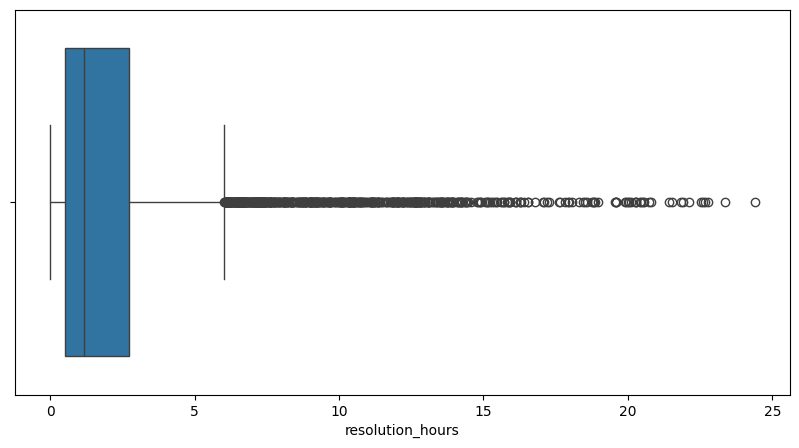

In [40]:
import seaborn as sns

sns.boxplot(x=df["resolution_hours"])

In the 10,000 most recent NYC 311 service requests, the median resolution time is approximately 2–3 hours. This reflects the fact that many complaint types (such as noise or illegal parking) are administratively closed very quickly, often after initial inspection, rather than long-term service resolution.